<a href="https://colab.research.google.com/github/aaderemi/GSoC/blob/main/synth_finetune_labram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r drive/MyDrive/npy_synthetic_ersp.zip npy_synthetic_data.zip
!unzip npy_synthetic_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/class4_500Hz_23dB_ersp_epochs/class4_500Hz_23dB_ersp_epoch_4170.npy  
  inflating: train/class4_500Hz_23dB_ersp_epochs/class4_500Hz_23dB_ersp_epoch_2180.npy  
  inflating: train/class4_500Hz_23dB_ersp_epochs/class4_500Hz_23dB_ersp_epoch_5840.npy  
  inflating: train/class4_500Hz_23dB_ersp_epochs/class4_500Hz_23dB_ersp_epoch_4835.npy  
  inflating: train/class4_500Hz_23dB_ersp_epochs/class4_500Hz_23dB_ersp_epoch_4789.npy  
  inflating: train/class4_500Hz_23dB_ersp_epochs/class4_500Hz_23dB_ersp_epoch_2524.npy  
  inflating: train/class4_500Hz_23dB_ersp_epochs/class4_500Hz_23dB_ersp_epoch_2012.npy  
  inflating: train/class4_500Hz_23dB_ersp_epochs/class4_500Hz_23dB_ersp_epoch_2101.npy  
  inflating: train/class4_500Hz_23dB_ersp_epochs/class4_500Hz_23dB_ersp_epoch_5274.npy  
  inflating: train/class4_500Hz_23dB_ersp_epochs/class4_500Hz_23dB_ersp_epoch_4779.npy  
  inflating: train/class4_500Hz_23dB_ersp_epochs/class4_500

In [ ]:
!cp drive/MyDrive/labram.zip labram.zip
!unzip labram.zip

Archive:  labram.zip
   creating: LaBraM/
   creating: LaBraM/checkpoints/
  inflating: LaBraM/checkpoints/labram-base.pth  
  inflating: LaBraM/checkpoints/vqnsp.pth  
  inflating: LaBraM/run_labram_pretraining.py  
  inflating: LaBraM/modeling_finetune.py  
  inflating: LaBraM/README.md        
  inflating: LaBraM/utils.py         
 extracting: LaBraM/.zip             
  inflating: LaBraM/modeling_pretrain.py  
  inflating: LaBraM/engine_for_finetuning.py  
   creating: LaBraM/data_processor/
   creating: LaBraM/data_processor/__pycache__/
  inflating: LaBraM/data_processor/__pycache__/dataset.cpython-310.pyc  
  inflating: LaBraM/data_processor/data_preprocess.py  
  inflating: LaBraM/data_processor/dataset.py  
   creating: LaBraM/.git/
 extracting: LaBraM/.git/HEAD        
  inflating: LaBraM/.git/index       
  inflating: LaBraM/.git/packed-refs  
   creating: LaBraM/.git/logs/
  inflating: LaBraM/.git/logs/HEAD   
   creating: LaBraM/.git/logs/refs/
   creating: LaBraM/.git/logs

In [ ]:
!pip install tensorboardX
!pip install pyhealth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.1

In [ ]:
!pip install wandb
!pip install mne
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 65.9 MB/s eta 0:00:00


In [ ]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.2 MB/s eta 0:00:00


In [ ]:
!cp drive/MyDrive/synthetic_mod.zip synthetic_mod.zip
!unzip synthetic_mod.zip

In [ ]:
import sys
sys.path.append('/content/LaBraM')
import json

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import wandb
from rich import print
from safetensors.torch import load_file
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, LeaveOneGroupOut
from transformers import get_scheduler
import mne
import sklearn
from mne.filter import filter_data
from sklearn.cluster import KMeans
from transformers import set_seed
import math
import timm
import copy
import captum

In [ ]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

    print(f"\nRandom seed value is initialized to: ", seed_value)

seed = 0
seed_everything(seed)
np.set_printoptions(precision=4)

os.environ["CUDA_VISIBLE_DEVICES"] = '3'

BLAES_data_path = "/home/zeydabadi/BLAES/BIP"

Random seed value is initialized to:  0

In [ ]:
#set seed with transformers set seed
set_seed(42)
batch_size = 64
num_epochs = 50

Fs = 500 #sampling frequency
num_channels = 19 #number of channels

BLAES_data_path = "/content/content/train"
model_path  = "/content/labram_pt_out/model_5.pth"
decay = 0.9999
patch_size = 500
embed_dim = 500
out_chans = embed_dim
num_classes = 4

max_value = 3.192746112311605 #maximum value in dataset for erp signals.

In [ ]:
wandb.login()

wandb: Currently logged in as: aaderemi (cmpe_dlai). Use `wandb login --relogin` to force relogin


True

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Computing device is: ", device)

Computing device is:  cuda

In [ ]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print("Computing device is: ", device)

Computing device is:  cpu

In [ ]:
def custom_balanced_accuracy(preds, targets):
    """
    Calculate the balanced accuracy score for PyTorch tensors.

    Args:
    - preds (torch.Tensor): The predicted labels.
    - targets (torch.Tensor): The true labels.

    Returns:
    - torch.Tensor: The balanced accuracy score.
    """
    unique_labels = torch.unique(targets)
    acc_per_class = torch.zeros(len(unique_labels))
    for i, label in enumerate(unique_labels):
        correct = preds[targets == label] == label
        acc_per_class[i] = correct.float().mean()
    balanced_acc = acc_per_class.mean()
    return balanced_acc

In [ ]:
from sklearn.metrics import  accuracy_score

In [ ]:
def training(train_loader, model, criterion, optimizer, scheduler, device):
    """
    Train a model.

    Args:
    - train_loader (torch.utils.data.DataLoader): The training data loader.
    - model (torch.nn.Module): The model to train.
    - criterion (torch.nn.Module): The loss function.
    - optimizer (torch.optim.Optimizer): The optimizer.
    - scheduler (torch.optim.lr_scheduler._LRScheduler): The learning rate scheduler.
    - device (torch.device): The device to run training on.

    Returns:
    - dict: A dictionary containing the average loss and accuracy.
    """
    # print('\nTraining...')
    avg_meters = {"loss": AverageMeter(), "acc": AverageMeter()}

    model.train()
    model.to(device)
    model_ema = timm.utils.ModelEma(model, decay=decay, device=device)
    #print("Number of bacthes (training): ", len(train_loader))


    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.float().to(device), labels.to(device)

        optimizer.zero_grad()

        try:
            output = model(data)
            loss = criterion(output, labels)
            if torch.isnan(loss):
                print(f"\nNaN loss encountered in batch {batch_idx} !!!!")
                continue  # Skip this batch
            loss.backward()

            # Gradient clipping
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) did not use gradient clipping while testing

            optimizer.step()
            scheduler.step()  # Correct placement for OneCycleLR scheduler, inside the batch loop
            model_ema.update(model)

            # Calculate the accuracy.
        except Exception as e:
            print(
                f"\nAn error occurred during training in batch {batch_idx}: {e}")
            continue

        avg_meters["loss"].update(loss.item(), data.size(0))

        #Sklearn balanced accuracy
        #acc = balanced_accuracy_score(labels.detach().cpu(), output.argmax(dim=-1).detach().cpu())
        #acc = custom_balanced_accuracy(output.argmax(dim=-1).detach().cpu(), labels.detach().cpu())
        acc = accuracy_score(labels.detach().cpu(), output.argmax(dim=-1).detach().cpu())
        avg_meters["acc"].update(acc.item(), data.size(0))

    # print(f'\nEnd of Training - Average Loss: {avg_meters["loss"].avg}, Average Accuracy: {avg_meters["acc"].avg}')
    return {"loss": avg_meters["loss"].avg, "acc": avg_meters["acc"].avg}

In [ ]:
def validation(validation_loader, model, criterion, device):
    """
    Validate a model.

    Args:
    - validation_loader (torch.utils.data.DataLoader): The validation data loader.
    - model (torch.nn.Module): The model to validate.
    - criterion (torch.nn.Module): The loss function.
    - device (torch.device): The device to run validation on.

    Returns:
    - dict: A dictionary containing the average loss and accuracy.
    """
    # print("\nValidating...")
    avg_meters = {"loss": AverageMeter(), "acc": AverageMeter()}

    model.eval()
    model.to(device)
    #print("Number of bacthes (validation): ", len(validation_loader))

    try:
        with torch.no_grad():
            for batch_idx, (data, labels) in enumerate(validation_loader):
                # No need to check for batch size if DataLoader is set to drop_last=True
                data, labels = data.float().to(device), labels.to(device)

                # Make prediction.
                output = model(data)

                # Calculate the loss.
                loss = criterion(output, labels)
                avg_meters["loss"].update(loss.item(), data.size(0))

                # Calculate the accuracy.
                #Sklearn balanced accuracy
                #acc = balanced_accuracy_score(labels.detach().cpu(), output.argmax(dim=-1).detach().cpu())
                #acc = custom_balanced_accuracy(output.argmax(dim=-1).detach().cpu(), labels.detach().cpu())
                acc = accuracy_score(labels.detach().cpu(), output.argmax(dim=-1).detach().cpu())
                avg_meters["acc"].update(acc.item(), data.size(0))

        # print(f'\nAverage Validation Loss: {avg_meters["loss"].avg}, Average Validation Accuracy: {avg_meters["acc"].avg}')
        return {"loss": avg_meters["loss"].avg, "acc": avg_meters["acc"].avg}
    except Exception as e:
        print(f"\nAn error occurred during validation: {e}")
        return {"loss": None, "acc": None}

# SSL


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def list_files_with_extension(root_folder, extension):
    """
    List all files with a specific extension in a folder and its subfolders.

    Parameters:
    - root_folder (str): The root folder to start the search.
    - extension (str): The file extension to look for (e.g., '.txt').

    Returns:
    - List of file paths with the specified extension.
    """
    matching_files = []
    walk_list = list(os.walk(root_folder))
    sorted_walk_list = sorted(walk_list, key=lambda x: x[0])

    # Traverse the directory tree
    for dirpath, dirnames, filenames in sorted_walk_list:
        for filename in filenames:
            if filename.endswith(extension):
                full_path = os.path.join(dirpath, filename)
                matching_files.append(full_path)

    return matching_files

In [ ]:
# im using dataset class from shared file
class EEGDataset(torch.utils.data.Dataset):
  def __init__(self, items):
      self.items = items
      np.random.shuffle(self.items)
      # self.items = self.filter_valid_files(all_items)

  def __len__(self):
      return len(self.items)

  def get_filename(self, idx):
      return self.items[idx]

  def __getitem__(self, idx):
      file_id = self.items[idx]
      data = np.load(file_id)/max_value #normalize
      data = torch.tensor(data, dtype = torch.float32)

      data = data.reshape(19, -1, patch_size)

      label = int(file_id.split('/')[-2].split('_')[0][-1])

      return data, torch.tensor(label-1, dtype = torch.long)

In [ ]:
class1_files = list_files_with_extension("/content/train/class1_500Hz_23dB_ersp_epochs", '.npy')
class2_files = list_files_with_extension("/content/train/class2_500Hz_23dB_ersp_epochs", '.npy')
class3_files = list_files_with_extension("/content/train/class3_500Hz_23dB_ersp_epochs", '.npy')
class4_files = list_files_with_extension("/content/train/class4_500Hz_23dB_ersp_epochs", '.npy')

In [ ]:
len(class1_files), len(class2_files), len(class3_files), len(class4_files)

(6000, 6000, 6000, 6000)

In [ ]:
train_items = class1_files[:500]+class2_files[:500]+class3_files[:500]+class4_files[:500]

#+class3_files[:500]+class4_files[:500]
val_items = class1_files[1000:1100]+class2_files[1000:1100]+class3_files[1000:1100]+class4_files[1000:1100]

#+class3_files[500:600]+class4_files[500:600]

In [ ]:
train_ds = EEGDataset(train_items)
val_ds = EEGDataset(val_items)

In [ ]:
len(train_ds), len(val_ds)

(2000, 400)

In [ ]:
train_ds.items[0], val_ds.items[0]

('/content/train/class4_500Hz_23dB_ersp_epochs/class4_500Hz_23dB_ersp_epoch_1681.npy',
 '/content/train/class2_500Hz_23dB_ersp_epochs/class2_500Hz_23dB_ersp_epoch_942.npy')

In [ ]:
train_ds[0][1], val_ds[0][1]

(tensor(3), tensor(1))

In [ ]:
from functools import partial
from timm.models.layers import drop_path, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from einops import rearrange
from collections import OrderedDict


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5),
        **kwargs
    }


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

    def extra_repr(self) -> str:
        return 'p={}'.format(self.drop_prob)


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        # x = self.drop(x)
        # commit this for the orignal BERT implement
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(
            self, dim, num_heads=8, qkv_bias=False, qk_norm=None, qk_scale=None, attn_drop=0.,
            proj_drop=0., window_size=None, attn_head_dim=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        if attn_head_dim is not None:
            head_dim = attn_head_dim
        all_head_dim = head_dim * self.num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, all_head_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(all_head_dim))
            self.v_bias = nn.Parameter(torch.zeros(all_head_dim))
        else:
            self.q_bias = None
            self.v_bias = None

        if qk_norm is not None:
            self.q_norm = qk_norm(head_dim)
            self.k_norm = qk_norm(head_dim)
        else:
            self.q_norm = None
            self.k_norm = None

        if window_size:
            self.window_size = window_size
            self.num_relative_distance = (2 * window_size[0] - 1) * (2 * window_size[1] - 1) + 3
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros(self.num_relative_distance, num_heads))  # 2*Wh-1 * 2*Ww-1, nH
            # cls to token & token 2 cls & cls to cls

            # get pair-wise relative position index for each token inside the window
            coords_h = torch.arange(window_size[0])
            coords_w = torch.arange(window_size[1])
            coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
            coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
            relative_coords[:, :, 0] += window_size[0] - 1  # shift to start from 0
            relative_coords[:, :, 1] += window_size[1] - 1
            relative_coords[:, :, 0] *= 2 * window_size[1] - 1
            relative_position_index = \
                torch.zeros(size=(window_size[0] * window_size[1] + 1, ) * 2, dtype=relative_coords.dtype)
            relative_position_index[1:, 1:] = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
            relative_position_index[0, 0:] = self.num_relative_distance - 3
            relative_position_index[0:, 0] = self.num_relative_distance - 2
            relative_position_index[0, 0] = self.num_relative_distance - 1

            self.register_buffer("relative_position_index", relative_position_index)
        else:
            self.window_size = None
            self.relative_position_bias_table = None
            self.relative_position_index = None

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(all_head_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, rel_pos_bias=None, return_attention=False, return_qkv=False):
        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        # qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple) (B, H, N, C)
        if self.q_norm is not None:
            q = self.q_norm(q).type_as(v)
        if self.k_norm is not None:
            k = self.k_norm(k).type_as(v)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        if self.relative_position_bias_table is not None:
            relative_position_bias = \
                self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
                    self.window_size[0] * self.window_size[1] + 1,
                    self.window_size[0] * self.window_size[1] + 1, -1)  # Wh*Ww,Wh*Ww,nH
            relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
            attn = attn + relative_position_bias.unsqueeze(0)

        if rel_pos_bias is not None:
            attn = attn + rel_pos_bias

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        if return_attention:
            return attn

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)

        x = self.proj(x)
        x = self.proj_drop(x)

        if return_qkv:
            return x, qkv

        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_norm=None, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., init_values=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 window_size=None, attn_head_dim=None):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_norm=qk_norm, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, window_size=window_size, attn_head_dim=attn_head_dim)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if init_values > 0:
            self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
            self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
        else:
            self.gamma_1, self.gamma_2 = None, None

    def forward(self, x, rel_pos_bias=None, return_attention=False, return_qkv=False):
        if return_attention:
            return self.attn(self.norm1(x), rel_pos_bias=rel_pos_bias, return_attention=True)
        if return_qkv:
            y, qkv = self.attn(self.norm1(x), rel_pos_bias=rel_pos_bias, return_qkv=return_qkv)
            x = x + self.drop_path(self.gamma_1 * y)
            x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
            return x, qkv

        if self.gamma_1 is None:
            x = x + self.drop_path(self.attn(self.norm1(x), rel_pos_bias=rel_pos_bias))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        else:
            x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x), rel_pos_bias=rel_pos_bias))
            x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ EEG to Patch Embedding
    """
    def __init__(self, EEG_size=2000, patch_size=200, in_chans=1, embed_dim=200):
        super().__init__()
        # EEG_size = to_2tuple(EEG_size)
        # patch_size = to_2tuple(patch_size)
        num_patches = 62 * (EEG_size // patch_size)
        self.patch_shape = (1, EEG_size // patch_size)
        self.EEG_size = EEG_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=(1, patch_size), stride=(1, patch_size))

    def forward(self, x, **kwargs):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class TemporalConv(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, in_chans=1, out_chans=8):
        super().__init__()
        self.conv1 = nn.Conv2d(in_chans, out_chans, kernel_size=(1, 15), stride=(1, 8), padding=(0, 7))
        self.gelu1 = nn.GELU()
        self.norm1 = nn.GroupNorm(4, out_chans)
        self.conv2 = nn.Conv2d(out_chans, out_chans, kernel_size=(1, 3), padding=(0, 1))
        self.gelu2 = nn.GELU()
        self.norm2 = nn.GroupNorm(4, out_chans)
        self.conv3 = nn.Conv2d(out_chans, out_chans, kernel_size=(1, 3), padding=(0, 1))
        self.norm3 = nn.GroupNorm(4, out_chans)
        self.gelu3 = nn.GELU()

        self.pooling = nn.AdaptiveAvgPool2d((None, 1))

    def forward(self, x, **kwargs):
        x = rearrange(x, 'B N A T -> B (N A) T')
        B, NA, T = x.shape
        x = x.unsqueeze(1)
        x = self.gelu1(self.norm1(self.conv1(x)))
        x = self.gelu2(self.norm2(self.conv2(x)))
        x = self.gelu3(self.norm3(self.conv3(x)))
        #x = rearrange(x, 'B C NA T -> B NA (T C)')
        x = self.pooling(x)
        x = x.squeeze(-1).transpose(1, 2)
        #print(x.shape)
        return x


class NeuralTransformer(nn.Module):
    def __init__(self, EEG_size=1600, patch_size=200, in_chans=1, out_chans=8, num_classes=1000, embed_dim=200, depth=12,
                 num_heads=10, mlp_ratio=4., qkv_bias=False, qk_norm=None, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, init_values=None,
                 use_abs_pos_emb=True, use_rel_pos_bias=False, use_shared_rel_pos_bias=False,
                 use_mean_pooling=True, init_scale=0.001, **kwargs):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        # To identify whether it is neural tokenizer or neural decoder.
        # For the neural decoder, use linear projection (PatchEmbed) to project codebook dimension to hidden dimension.
        # Otherwise, use TemporalConv to extract temporal features from EEG signals.
        self.patch_embed = TemporalConv(out_chans=out_chans) if in_chans == 1 else PatchEmbed(EEG_size=EEG_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        self.time_window = EEG_size // patch_size
        self.patch_size = patch_size

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # self.mask_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        if use_abs_pos_emb:
            self.pos_embed = nn.Parameter(torch.zeros(1, 128 + 1, embed_dim), requires_grad=True)
        else:
            self.pos_embed = None
        self.time_embed = nn.Parameter(torch.zeros(1, 60, embed_dim), requires_grad=True)
        self.pos_drop = nn.Dropout(p=drop_rate)

        self.rel_pos_bias = None

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.use_rel_pos_bias = use_rel_pos_bias
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_norm=qk_norm, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                init_values=init_values, window_size=None)
            for i in range(depth)])
        self.norm = nn.Identity() if use_mean_pooling else norm_layer(embed_dim)
        self.fc_norm = norm_layer(embed_dim) if use_mean_pooling else None
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        if self.pos_embed is not None:
            trunc_normal_(self.pos_embed, std=.02)
        if self.time_embed is not None:
            trunc_normal_(self.time_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        # trunc_normal_(self.mask_token, std=.02)
        if isinstance(self.head, nn.Linear):
            trunc_normal_(self.head.weight, std=.02)
        self.apply(self._init_weights)
        self.fix_init_weight()

        if isinstance(self.head, nn.Linear):
            self.head.weight.data.mul_(init_scale)
            self.head.bias.data.mul_(init_scale)

    def fix_init_weight(self):
        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def get_num_layers(self):
        return len(self.blocks)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token', 'time_embed'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x, input_chans=None, return_patch_tokens=False, return_all_tokens=False, **kwargs):
        batch_size, n, a, t = x.shape

        input_time_window = a if t == self.patch_size else t

        x = self.patch_embed(x)
        #print(x.shape)

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks

        x = torch.cat((cls_tokens, x), dim=1)

        pos_embed_used = self.pos_embed[:, input_chans] if input_chans is not None else self.pos_embed
        num_pos = n if t == self.patch_size else input_time_window
        if self.pos_embed is not None:
            pos_embed = pos_embed_used[:, 1:num_pos+1, :].unsqueeze(2).expand(batch_size, -1, input_time_window, -1).flatten(1, 2)
            pos_embed = torch.cat((pos_embed_used[:,0:1,:].expand(batch_size, -1, -1), pos_embed), dim=1)
            #print(pos_embed.shape)
            x = x + pos_embed


        if self.time_embed is not None:
            nc = n if t == self.patch_size else a
            time_embed = self.time_embed[:, 0:input_time_window, :].unsqueeze(1).expand(batch_size, nc, -1, -1).flatten(1, 2)
            x[:, 1:, :] += time_embed

        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x, rel_pos_bias=None)

        x = self.norm(x)
        if self.fc_norm is not None:
            if return_all_tokens:
                return self.fc_norm(x)
            t = x[:, 1:, :]
            if return_patch_tokens:
                return self.fc_norm(t)
            else:
                return self.fc_norm(t.mean(1))
        else:
            if return_all_tokens:
                return x
            elif return_patch_tokens:
                return x[:, 1:]
            else:
                return x[:, 0]

    def forward(self, x, input_chans=None, return_patch_tokens=False, return_all_tokens=False, **kwargs):
        '''
        x: [batch size, number of electrodes, number of patches, patch size]
        For example, for an EEG sample of 4 seconds with 64 electrodes, x will be [batch size, 64, 4, 200]
        '''
        x = self.forward_features(x, input_chans=input_chans, return_patch_tokens=return_patch_tokens, return_all_tokens=return_all_tokens, **kwargs)
        if return_patch_tokens:
            return x, self.head(x.mean(1))
        x = self.head(x)
        return x

    def forward_intermediate(self, x, layer_id=12, norm_output=False):
        x = self.patch_embed(x)
        batch_size, seq_len, _ = x.size()

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        if self.pos_embed is not None:
            pos_embed = self.pos_embed[:, 1:, :].unsqueeze(2).expand(batch_size, -1, self.time_window, -1).flatten(1, 2)
            pos_embed = torch.cat((self.pos_embed[:,0:1,:].expand(batch_size, -1, -1), pos_embed), dim=1)
            x = x + pos_embed
        if self.time_embed is not None:
            time_embed = self.time_embed.unsqueeze(1).expand(batch_size, 62, -1, -1).flatten(1, 2)
            x[:, 1:, :] += time_embed
        x = self.pos_drop(x)

        rel_pos_bias = self.rel_pos_bias() if self.rel_pos_bias is not None else None
        if isinstance(layer_id, list):
            output_list = []
            for l, blk in enumerate(self.blocks):
                x = blk(x, rel_pos_bias=rel_pos_bias)
                # use last norm for all intermediate layers
                if l in layer_id:
                    if norm_output:
                        x_norm = self.fc_norm(self.norm(x[:, 1:]))
                        output_list.append(x_norm)
                    else:
                        output_list.append(x[:, 1:])
            return output_list
        elif isinstance(layer_id, int):
            for l, blk in enumerate(self.blocks):
                if l < layer_id:
                    x = blk(x, rel_pos_bias=rel_pos_bias)
                elif l == layer_id:
                    x = blk.norm1(x)
                else:
                    break
            return x[:, 1:]
        else:
            raise NotImplementedError(f"Not support for layer id is {layer_id} now!")

    def get_intermediate_layers(self, x, use_last_norm=False):
        x = self.patch_embed(x)
        batch_size, seq_len, _ = x.size()
        #print(x.shape)

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        if self.pos_embed is not None:
            pos_embed = self.pos_embed[:, 1:, :].unsqueeze(2).expand(batch_size, -1, self.time_window, -1).flatten(1, 2)
            pos_embed = torch.cat((self.pos_embed[:,0:1,:].expand(batch_size, -1, -1), pos_embed), dim=1)
            #print(pos_embed.shape)
            x = x + pos_embed
        if self.time_embed is not None:
            time_embed = self.time_embed.unsqueeze(1).expand(batch_size, 62, -1, -1).flatten(1, 2)
            x[:, 1:, :] += time_embed
        x = self.pos_drop(x)

        features = []
        rel_pos_bias = self.rel_pos_bias() if self.rel_pos_bias is not None else None
        for blk in self.blocks:
            x = blk(x, rel_pos_bias)
            if use_last_norm:
                features.append(self.norm(x))
            else:
                features.append(x)

        return features


In [ ]:
def load_state_dict(model, state_dict, prefix='', ignore_missing="relative_position_index"):
    missing_keys = []
    unexpected_keys = []
    error_msgs = []
    # copy state_dict so _load_from_state_dict can modify it
    metadata = getattr(state_dict, '_metadata', None)
    state_dict = state_dict.copy()
    if metadata is not None:
        state_dict._metadata = metadata

    def load(module, prefix=''):
        local_metadata = {} if metadata is None else metadata.get(
            prefix[:-1], {})
        module._load_from_state_dict(
            state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs)
        for name, child in module._modules.items():
            if child is not None:
                load(child, prefix + name + '.')

    load(model, prefix=prefix)

    warn_missing_keys = []
    ignore_missing_keys = []
    for key in missing_keys:
        keep_flag = True
        for ignore_key in ignore_missing.split('|'):
            if ignore_key in key:
                keep_flag = False
                break
        if keep_flag:
            warn_missing_keys.append(key)
        else:
            ignore_missing_keys.append(key)

    missing_keys = warn_missing_keys

    if len(missing_keys) > 0:
        print("Weights of {} not initialized from pretrained model: {}".format(
            model.__class__.__name__, missing_keys))
    if len(unexpected_keys) > 0:
        print("Weights from pretrained model not used in {}: {}".format(
            model.__class__.__name__, unexpected_keys))
    if len(ignore_missing_keys) > 0:
        print("Ignored weights of {} not initialized from pretrained model: {}".format(
            model.__class__.__name__, ignore_missing_keys))
    if len(error_msgs) > 0:
        print('\n'.join(error_msgs))

In [ ]:
def init_model(model_path,  num_classes=num_classes, random_init = False):

  model = NeuralTransformer(
        patch_size=patch_size, embed_dim=embed_dim, depth=12, num_heads=10, mlp_ratio=4, qk_norm=partial(nn.LayerNorm, eps=1e-6), qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), init_values=0.1, use_abs_pos_emb=True, num_classes=num_classes, out_chans=embed_dim, use_mean_pooling=True)

  state_dict = torch.load(model_path, map_location=device)

  #return model without pretraining weights
  if random_init:
    return model

  checkpoint_model = state_dict

  if (checkpoint_model is not None):
      all_keys = list(checkpoint_model.keys())
      new_dict = OrderedDict()
      for key in all_keys:
          if key.startswith('student.'):
              new_dict[key[8:]] = checkpoint_model[key]
          else:
              pass
      checkpoint_model = new_dict

  state_dictn = model.state_dict()
  for k in ['head.weight', 'head.bias']:
      if k in checkpoint_model and checkpoint_model[k].shape != state_dictn[k].shape:
          print(f"Removing key {k} from pretrained checkpoint")
          del checkpoint_model[k]

  all_keys = list(checkpoint_model.keys())
  for key in all_keys:
      if "relative_position_index" in key:
          checkpoint_model.pop(key)

  load_state_dict(model, checkpoint_model)

  return model

In [ ]:
def main_training_loop(base_directory, train_func, val_func, device, model_path):
    results = []


    #Pass both models to classifier model and do classifier training
    #set random_init=True to train without pretrained model
    classifier_model = init_model(model_path, random_init=False)

    run = wandb.init(
          project="Synth_finetune_ersp_werp_pt",
          config={
              "bs": batch_size,
              "num_epochs": num_epochs
          },
          name=f"small_50epochs"
      )



    trn_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
    val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)

    #criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32, device=device))
    criterion = nn.CrossEntropyLoss()


    optimizer = optim.Adam(classifier_model.parameters(), lr=1e-5, weight_decay = 0., betas = (0.9, 0.999))

    scheduler = get_scheduler("linear", optimizer, num_warmup_steps=10, num_training_steps=num_epochs*len(trn_dl))

    per_epoch_val_acc = []
    min_error = 100
    best_model = None
    for epoch in range(num_epochs):

      train_results = train_func(trn_dl, classifier_model, criterion, optimizer, scheduler, device)
      val_results = val_func(val_dl, classifier_model, criterion, device)
      wandb.log({"train_loss": train_results['loss'], "train_acc": train_results['acc'],
                    "val_loss": val_results['loss'], "val_acc": val_results['acc']})

      per_epoch_val_acc.append(val_results['acc'])

      print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {train_results['loss']:.4f} Val Loss: {val_results['loss']:.4f} Val Acc: {val_results['acc']:.4f}")

      if val_results['loss'] < min_error:
        min_error = val_results['loss']
        best_model = copy.deepcopy(classifier_model)

    results.append(
        {
          'train_loss': train_results['loss'],
          'train_acc': train_results['acc'],
          'val_loss': val_results['loss'],
          'val_acc': np.max(per_epoch_val_acc) #Report the maximum accuracy as opposed to the last one
      }
    )
    torch.cuda.empty_cache()
    wandb.finish()
    return results, best_model

In [ ]:
r, best_model = main_training_loop(BLAES_data_path, training, validation, device, model_path)

Weights of NeuralTransformer not initialized from pretrained model: ['fc_norm.weight', 'fc_norm.bias', 
'head.weight', 'head.bias']

Weights from pretrained model not used in NeuralTransformer: ['mask_token', 'lm_head.weight', 'lm_head.bias', 
'norm.weight', 'norm.bias']

Epoch 1/50 Train Loss: 1.3865 Val Loss: 1.3859 Val Acc: 0.2550

Epoch 2/50 Train Loss: 1.3843 Val Loss: 1.3782 Val Acc: 0.2500

Epoch 3/50 Train Loss: 1.3212 Val Loss: 1.2253 Val Acc: 0.5000

Epoch 4/50 Train Loss: 1.2136 Val Loss: 1.1154 Val Acc: 0.5025

Epoch 5/50 Train Loss: 1.0803 Val Loss: 1.0010 Val Acc: 0.5000

Epoch 6/50 Train Loss: 0.9853 Val Loss: 0.9419 Val Acc: 0.5050

Epoch 7/50 Train Loss: 0.9325 Val Loss: 0.8855 Val Acc: 0.5000

Epoch 8/50 Train Loss: 0.8809 Val Loss: 0.9723 Val Acc: 0.5100

Epoch 9/50 Train Loss: 0.8667 Val Loss: 0.8292 Val Acc: 0.5000

Epoch 10/50 Train Loss: 0.8273 Val Loss: 0.8142 Val Acc: 0.5200

Epoch 11/50 Train Loss: 0.8275 Val Loss: 0.7956 Val Acc: 0.5325

Epoch 12/50 Train Loss: 0.7952 Val Loss: 0.7837 Val Acc: 0.5525

Epoch 13/50 Train Loss: 0.7825 Val Loss: 0.7731 Val Acc: 0.5700

Epoch 14/50 Train Loss: 0.7787 Val Loss: 0.7929 Val Acc: 0.5775

Epoch 15/50 Train Loss: 0.8023 Val Loss: 0.8476 Val Acc: 0.4500

Epoch 16/50 Train Loss: 0.7701 Val Loss: 0.7507 Val Acc: 0.5925

Epoch 17/50 Train Loss: 0.7549 Val Loss: 0.7431 Val Acc: 0.6250

Epoch 18/50 Train Loss: 0.7407 Val Loss: 0.7371 Val Acc: 0.7625

Epoch 19/50 Train Loss: 0.7319 Val Loss: 0.7201 Val Acc: 0.7900

Epoch 20/50 Train Loss: 0.7084 Val Loss: 0.6931 Val Acc: 0.8850

Epoch 21/50 Train Loss: 0.6797 Val Loss: 0.6740 Val Acc: 0.8825

Epoch 22/50 Train Loss: 0.6502 Val Loss: 0.6243 Val Acc: 0.9325

Epoch 23/50 Train Loss: 0.6054 Val Loss: 0.5807 Val Acc: 0.9775

Epoch 24/50 Train Loss: 0.5576 Val Loss: 0.5256 Val Acc: 0.9900

Epoch 25/50 Train Loss: 0.5060 Val Loss: 0.4733 Val Acc: 0.9925

Epoch 26/50 Train Loss: 0.4600 Val Loss: 0.4276 Val Acc: 0.9975

Epoch 27/50 Train Loss: 0.4139 Val Loss: 0.3963 Val Acc: 1.0000

Epoch 28/50 Train Loss: 0.3822 Val Loss: 0.3659 Val Acc: 0.9975

Epoch 29/50 Train Loss: 0.3614 Val Loss: 0.3471 Val Acc: 0.9975

Epoch 30/50 Train Loss: 0.3368 Val Loss: 0.3238 Val Acc: 1.0000

Epoch 31/50 Train Loss: 0.3169 Val Loss: 0.3072 Val Acc: 1.0000

Epoch 32/50 Train Loss: 0.3017 Val Loss: 0.2933 Val Acc: 1.0000

Epoch 33/50 Train Loss: 0.2882 Val Loss: 0.2827 Val Acc: 1.0000

Epoch 34/50 Train Loss: 0.2785 Val Loss: 0.2699 Val Acc: 1.0000

Epoch 35/50 Train Loss: 0.2668 Val Loss: 0.2606 Val Acc: 1.0000

Epoch 36/50 Train Loss: 0.2583 Val Loss: 0.2526 Val Acc: 1.0000

Epoch 37/50 Train Loss: 0.2506 Val Loss: 0.2455 Val Acc: 1.0000

Epoch 38/50 Train Loss: 0.2430 Val Loss: 0.2388 Val Acc: 1.0000

Epoch 39/50 Train Loss: 0.2368 Val Loss: 0.2329 Val Acc: 1.0000

Epoch 40/50 Train Loss: 0.2314 Val Loss: 0.2277 Val Acc: 1.0000

Epoch 41/50 Train Loss: 0.2265 Val Loss: 0.2234 Val Acc: 1.0000

Epoch 42/50 Train Loss: 0.2221 Val Loss: 0.2195 Val Acc: 1.0000

Epoch 43/50 Train Loss: 0.2184 Val Loss: 0.2163 Val Acc: 1.0000

Epoch 44/50 Train Loss: 0.2153 Val Loss: 0.2134 Val Acc: 1.0000

Epoch 45/50 Train Loss: 0.2126 Val Loss: 0.2110 Val Acc: 1.0000

Epoch 46/50 Train Loss: 0.2105 Val Loss: 0.2091 Val Acc: 1.0000

Epoch 47/50 Train Loss: 0.2087 Val Loss: 0.2077 Val Acc: 1.0000

Epoch 48/50 Train Loss: 0.2074 Val Loss: 0.2066 Val Acc: 1.0000

Epoch 49/50 Train Loss: 0.2066 Val Loss: 0.2060 Val Acc: 1.0000

Epoch 50/50 Train Loss: 0.2061 Val Loss: 0.2058 Val Acc: 1.0000

train_acc,▁▁▃▃▃▃▃▃▄▄▄▄▄▄▅▆▇▇██████████████████████
train_loss,███▇▆▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▃▃▃▃▃▃▄▄▄▄▄▅▆▆▇▇██████████████████████
val_loss,██▇▆▅▅▆▅▄▄▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,1.0
train_loss,0.20611
val_acc,1.0
val_loss,0.20575


In [ ]:
best_model.eval()

In [ ]:
deeplift_model = captum.attr.DeepLift(best_model)

In [ ]:
#choose input and target
sample_idx = 5
input = val_ds[sample_idx][0].unsqueeze(0).to(device)
target = val_ds[sample_idx][1]

input.requires_grad = True

In [ ]:
baseline = input*0

In [ ]:
attributions, delta = deeplift_model.attribute(input, baseline, target=target, return_convergence_delta=True)

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [ ]:
attributions = attributions.squeeze(0)

In [ ]:
best_model(input)

tensor([[ 2.2029, -0.0916, -2.1566, -0.1534]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
target

tensor(0)

In [ ]:
#obtain mean attribution for each patch
mean_attributions = torch.mean(attributions, dim=-1)

In [ ]:
def get_patch_with_high_attributions(mean_attributions, k):
  #returns top k patches with highest positive attributions
  idxs = torch.argsort(mean_attributions.reshape(-1), descending=True)
  top_k = idxs[:k]

  top_k = [(idx.item()//10, idx.item() - (idx.item()//10)*10) for idx in top_k]
  return top_k

In [ ]:
#get indices for patches with highest attribution
#question is if these indices match with patches that we expect to have highest positive attribution
patch_idxs = get_patch_with_high_attributions(mean_attributions, 5)

In [ ]:
#first index is channel index, second is time index
patch_idxs

[(11, 1), (11, 4), (16, 4), (16, 8), (15, 1)]

In [ ]:
original_attributions = attributions.reshape(19, -1) #flatten attr

In [ ]:
#choose channel from patch_idxs
ch = 16

Text(0.5, 0, 'Time(s)')

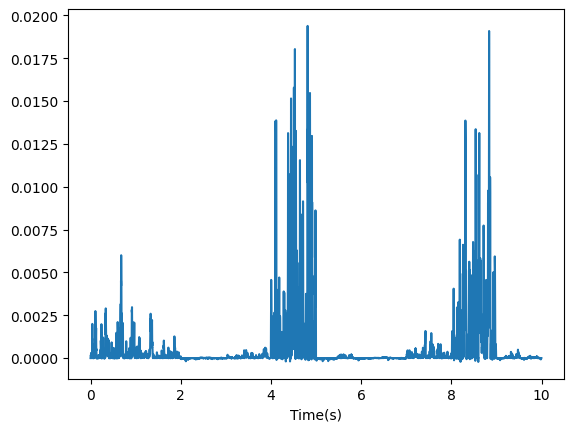

In [ ]:
plt.plot(np.arange(5000)/500, original_attributions[ch].cpu().detach().numpy())
plt.xlabel("Time(s)")

In [ ]:
# --------------------------------------------------------
# Large Brain Model for Learning Generic Representations with Tremendous EEG Data in BCI
# By Wei-Bang Jiang
# Based on BEiT-v2, timm, DeiT, and DINO code bases
# https://github.com/microsoft/unilm/tree/master/beitv2
# https://github.com/rwightman/pytorch-image-models/tree/master/timm
# https://github.com/facebookresearch/deit/
# https://github.com/facebookresearch/dino
# ---------------------------------------------------------
import math
import sys
from typing import Iterable, Optional
import torch
from timm.utils import ModelEma
import LaBraM.utils as utils
from einops import rearrange

def train_class_batch(model, samples, target, criterion, ch_names):
    outputs = model(samples, ch_names)
    loss = criterion(outputs, target)
    return loss, outputs


def get_loss_scale_for_deepspeed(model):
    optimizer = model.optimizer
    return optimizer.loss_scale if hasattr(optimizer, "loss_scale") else optimizer.cur_scale


def train_one_epoch(model: torch.nn.Module, criterion: torch.nn.Module,
                    data_loader: Iterable, optimizer: torch.optim.Optimizer,
                    device: torch.device, epoch: int, loss_scaler, max_norm: float = 0,
                    model_ema: Optional[ModelEma] = None, log_writer=None,
                    start_steps=None, lr_schedule_values=None, wd_schedule_values=None,
                    num_training_steps_per_epoch=None, update_freq=None, ch_names=None, is_binary=True):
    input_chans = None
    if ch_names is not None:
        input_chans = utils.get_input_chans(ch_names)
    model.train(True)
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    metric_logger.add_meter('min_lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 10

    if loss_scaler is None:
        model.zero_grad()
        model.micro_steps = 0
    else:
        optimizer.zero_grad()

    for data_iter_step, (samples, targets) in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
        step = data_iter_step // update_freq
        if step >= num_training_steps_per_epoch:
            continue
        it = start_steps + step  # global training iteration
        # Update LR & WD for the first acc
        if lr_schedule_values is not None or wd_schedule_values is not None and data_iter_step % update_freq == 0:
            for i, param_group in enumerate(optimizer.param_groups):
                if lr_schedule_values is not None:
                    param_group["lr"] = lr_schedule_values[it] * param_group.get("lr_scale", 1.0)
                if wd_schedule_values is not None and param_group["weight_decay"] > 0:
                    param_group["weight_decay"] = wd_schedule_values[it]

        samples = samples.float().to(device, non_blocking=True)
        #samples = rearrange(samples, 'B N (A T) -> B N A T', T=200)

        targets = targets.to(device, non_blocking=True)
        if is_binary:
            targets = targets.float().unsqueeze(-1)

        if loss_scaler is None:
            samples = samples.half()
            loss, output = train_class_batch(
                model, samples, targets, criterion, input_chans)
        else:
            with torch.cuda.amp.autocast(enabled=False):
                loss, output = train_class_batch(
                    model, samples, targets, criterion, input_chans)

        loss_value = loss.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        if loss_scaler is None:
            loss /= update_freq
            model.backward(loss)
            model.step()

            if (data_iter_step + 1) % update_freq == 0:
                # model.zero_grad()
                # Deepspeed will call step() & model.zero_grad() automatic
                if model_ema is not None:
                    model_ema.update(model)
            grad_norm = None
            #loss_scale_value = get_loss_scale_for_deepspeed(model)
        else:
            # this attribute is added by timm on one optimizer (adahessian)
            is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
            loss /= update_freq
            grad_norm = loss_scaler(loss, optimizer, clip_grad=max_norm,
                                    parameters=model.parameters(), create_graph=is_second_order,
                                    update_grad=(data_iter_step + 1) % update_freq == 0)
            if (data_iter_step + 1) % update_freq == 0:
                optimizer.zero_grad()
                if model_ema is not None:
                    model_ema.update(model)
            #loss_scale_value = loss_scaler.state_dict()["scale"]

        #torch.cuda.synchronize()

        if is_binary:
            class_acc = utils.get_metrics(torch.sigmoid(output).detach().cpu().numpy(), targets.detach().cpu().numpy(), ["accuracy"], is_binary)["accuracy"]
        else:
            class_acc = (output.max(-1)[-1] == targets.squeeze()).float().mean()

        metric_logger.update(loss=loss_value)
        metric_logger.update(class_acc=class_acc)
        #metric_logger.update(loss_scale=loss_scale_value)
        min_lr = 10.
        max_lr = 0.
        for group in optimizer.param_groups:
            min_lr = min(min_lr, group["lr"])
            max_lr = max(max_lr, group["lr"])

        metric_logger.update(lr=max_lr)
        metric_logger.update(min_lr=min_lr)
        weight_decay_value = None
        for group in optimizer.param_groups:
            if group["weight_decay"] > 0:
                weight_decay_value = group["weight_decay"]
        metric_logger.update(weight_decay=weight_decay_value)
        metric_logger.update(grad_norm=grad_norm)

        if log_writer is not None:
            log_writer.update(loss=loss_value, head="loss")
            log_writer.update(class_acc=class_acc, head="loss")
            #log_writer.update(loss_scale=loss_scale_value, head="opt")
            log_writer.update(lr=max_lr, head="opt")
            log_writer.update(min_lr=min_lr, head="opt")
            log_writer.update(weight_decay=weight_decay_value, head="opt")
            log_writer.update(grad_norm=grad_norm, head="opt")

            log_writer.set_step()

    # gather the stats from all processes
    #metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}


@torch.no_grad()
def evaluate(data_loader, model, device, header='Test:', ch_names=None, metrics=['acc'], is_binary=True):
    input_chans = None
    if ch_names is not None:
        input_chans = utils.get_input_chans(ch_names)
    if is_binary:
        criterion = torch.nn.BCEWithLogitsLoss()
    else:
        criterion = torch.nn.CrossEntropyLoss()

    metric_logger = utils.MetricLogger(delimiter="  ")
    #header = 'Test:'

    # switch to evaluation mode
    model.eval()
    pred = []
    true = []
    for step, batch in enumerate(metric_logger.log_every(data_loader, 10, header)):
        EEG = batch[0]
        target = batch[-1]
        EEG = EEG.float().to(device, non_blocking=True)
        #EEG = rearrange(EEG, 'B N (A T) -> B N A T', T=200)
        target = target.to(device, non_blocking=True)
        if is_binary:
            target = target.float().unsqueeze(-1)

        # compute output
        with torch.cuda.amp.autocast(enabled=False):
            output = model(EEG, input_chans=input_chans)
            loss = criterion(output, target)

        if is_binary:
            output = torch.sigmoid(output).cpu()
        else:
            output = output.cpu()
        target = target.cpu()

        results = utils.get_metrics(output.numpy(), target.numpy(), metrics, is_binary)
        pred.append(output)
        true.append(target)

        batch_size = EEG.shape[0]
        metric_logger.update(loss=loss.item())
        for key, value in results.items():
            metric_logger.meters[key].update(value, n=batch_size)
        #metric_logger.meters['acc5'].update(acc5.item(), n=batch_size)
    # gather the stats from all processes
    #metric_logger.synchronize_between_processes()
    print('* loss {losses.global_avg:.3f}'
          .format(losses=metric_logger.loss))

    pred = torch.cat(pred, dim=0).numpy()
    true = torch.cat(true, dim=0).numpy()

    ret = utils.get_metrics(pred, true, metrics, is_binary, 0.5)
    ret['loss'] = metric_logger.loss.global_avg
    return ret, (pred, true)

In [ ]:
from optim_factory import create_optimizer

In [ ]:
def do_train(args, model,  dataset_train_ls, dataset_val_ls, device):
  some_res = []
  log_writer = utils.TensorboardLogger(log_dir=args.log_dir)
  model.to(device)
  #num_training_steps_per_epoch = math.ceil(sum([len(dataset) for dataset in dataset_train_ls]) / args.batch_size)

  data_loader_train = torch.utils.data.DataLoader(
      dataset_train_ls[0],
      batch_size=args.batch_size,
      pin_memory=args.pin_mem,
      drop_last=False,
      shuffle=True,
  )
  data_loader_val = torch.utils.data.DataLoader(
            dataset_val_ls[0],
            batch_size=args.batch_size,
            pin_memory=args.pin_mem,
            drop_last=False,
            shuffle=False
        )

  model.to(device)

  model_ema = timm.utils.ModelEma(
            model,
            decay=args.model_ema_decay,
            device=device)
  n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

  total_batch_size = args.batch_size * args.update_freq
  num_training_steps_per_epoch = len(dataset_train_ls[0]) // total_batch_size

  assigner = None

  num_layers = model.get_num_layers()

  skip_weight_decay_list = model.no_weight_decay()
  if args.disable_weight_decay_on_rel_pos_bias:
      for i in range(num_layers):
          skip_weight_decay_list.add("blocks.%d.attn.relative_position_bias_table" % i)

  optimizer = create_optimizer(
            args, model, skip_list=skip_weight_decay_list,
            get_num_layer=assigner.get_layer_id if assigner is not None else None,
            get_layer_scale=assigner.get_scale if assigner is not None else None)
  loss_scaler = utils.NativeScalerWithGradNormCount()

  lr_schedule_values = utils.cosine_scheduler(
        args.lr, args.min_lr, args.epochs, num_training_steps_per_epoch,
        warmup_epochs=args.warmup_epochs, warmup_steps=args.warmup_steps,
    )
  if args.weight_decay_end is None:
      args.weight_decay_end = args.weight_decay
  wd_schedule_values = utils.cosine_scheduler(
      args.weight_decay, args.weight_decay_end, args.epochs, num_training_steps_per_epoch)
  print("Max WD = %.7f, Min WD = %.7f" % (max(wd_schedule_values), min(wd_schedule_values)))

  criterion = torch.nn.BCEWithLogitsLoss()

  for epoch in range(args.epochs):
    log_writer.set_step(epoch * num_training_steps_per_epoch * args.update_freq)

    train_stats = train_one_epoch(
            model, criterion, data_loader_train, optimizer,
            device, epoch, loss_scaler, args.clip_grad, model_ema,
            log_writer=log_writer, start_steps=epoch * num_training_steps_per_epoch,
            lr_schedule_values=lr_schedule_values, wd_schedule_values=wd_schedule_values,
            num_training_steps_per_epoch=num_training_steps_per_epoch, update_freq=args.update_freq,
            ch_names=None, is_binary=True
        )

    metrics = ["pr_auc", "roc_auc", "accuracy", "balanced_accuracy"]

    val_stats, r = evaluate(data_loader_val, model, device, header='Val:', ch_names=None, metrics=metrics, is_binary=True)
    print(f"Accuracy of the network on the {len(dataset_val_ls[0])} val EEG: {val_stats['accuracy']:.2f}%")

    some_res.append(r)

    for key, value in val_stats.items():

      if key == 'accuracy':
          log_writer.update(accuracy=value, head="val", step=epoch)
      elif key == 'balanced_accuracy':
          log_writer.update(balanced_accuracy=value, head="val", step=epoch)
      elif key == 'f1_weighted':
          log_writer.update(f1_weighted=value, head="val", step=epoch)
      elif key == 'pr_auc':
          log_writer.update(pr_auc=value, head="val", step=epoch)
      elif key == 'roc_auc':
          log_writer.update(roc_auc=value, head="val", step=epoch)
      elif key == 'cohen_kappa':
          log_writer.update(cohen_kappa=value, head="val", step=epoch)
      elif key == 'loss':
          log_writer.update(loss=value, head="val", step=epoch)


    log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                         **{f'val_{k}': v for k, v in val_stats.items()},
                         'epoch': epoch,
                         'n_parameters': n_parameters}
    if log_writer is not None:
        log_writer.flush()
    with open(os.path.join(args.output_dir, "log.txt"), mode="a", encoding="utf-8") as f:
        f.write(json.dumps(log_stats) + "\n")

  return some_res

In [ ]:
foundation_files, event_files, subjects = load_data(BLAES_data_path)

In [ ]:
training_ds = CustomBIPDataset(foundation_files[1:], event_files[1:])
validation_ds = CustomBIPDataset([foundation_files[0]], [event_files[0]])

In [ ]:
model = init_model(model_path, num_classes=1)

Weights of NeuralTransformer not initialized from pretrained model: ['fc_norm.weight', 'fc_norm.bias', 
'head.weight', 'head.bias']

Weights from pretrained model not used in NeuralTransformer: ['mask_token', 'lm_head.weight', 'lm_head.bias', 
'norm.weight', 'norm.bias']

In [ ]:
some_res = do_train(args, model, [training_ds], [validation_ds], device)

Skip weight decay name marked in model: {'time_embed', 'cls_token', 'pos_embed'}
Param groups = {
  "no_decay": {
    "weight_decay": 0.0,
    "params": [
      "cls_token",
      "pos_embed",
      "time_embed",
      "patch_embed.conv1.bias",
      "patch_embed.norm1.weight",
      "patch_embed.norm1.bias",
      "patch_embed.conv2.bias",
      "patch_embed.norm2.weight",
      "patch_embed.norm2.bias",
      "patch_embed.conv3.bias",
      "patch_embed.norm3.weight",
      "patch_embed.norm3.bias",
      "blocks.0.gamma_1",
      "blocks.0.gamma_2",
      "blocks.0.norm1.weight",
      "blocks.0.norm1.bias",
      "blocks.0.attn.q_bias",
      "blocks.0.attn.v_bias",
      "blocks.0.attn.q_norm.weight",
      "blocks.0.attn.q_norm.bias",
      "blocks.0.attn.k_norm.weight",
      "blocks.0.attn.k_norm.bias",
      "blocks.0.attn.proj.bias",
      "blocks.0.norm2.weight",
      "blocks.0.norm2.bias",
      "blocks.0.mlp.fc1.bias",
      "blocks.0.mlp.fc2.bias",
      "blocks.1.gamma_

/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Max WD = 0.0500000, Min WD = 0.0500000

Epoch: [0]  [0/5]  eta: 0:01:18  lr: 0.000000  min_lr: 0.000000  loss: 0.6931 (0.6931)  class_acc: 0.7344 (0.7344)  weight_decay: 0.0500 (0.0500)  grad_norm: 3.9477 (3.9477)  time: 15.6934  data: 0.0071
Epoch: [0]  [4/5]  eta: 0:00:12  lr: 0.000158  min_lr: 0.000158  loss: 0.6905 (0.6904)  class_acc: 0.7344 (0.7383)  weight_decay: 0.0500 (0.0500)  grad_norm: 3.7349 (3.5870)  time: 12.7436  data: 0.0065
Epoch: [0] Total time: 0:01:03 (12.7447 s / it)


Averaged stats: lr: 0.000158  min_lr: 0.000158  loss: 0.6905 (0.6904)  class_acc: 0.7344 (0.7383)  weight_decay: 
0.0500 (0.0500)  grad_norm: 3.7349 (3.5870)

Val:  [0/3]  eta: 0:00:17  loss: 0.7082 (0.7082)  pr_auc: 0.9120 (0.9120)  roc_auc: 0.6407 (0.6407)  accuracy: 0.1562 (0.1562)  balanced_accuracy: 0.5000 (0.5000)  time: 5.7685  data: 0.0076
Val:  [2/3]  eta: 0:00:03  loss: 0.7082 (0.7078)  pr_auc: 0.8649 (0.8820)  roc_auc: 0.5172 (0.5636)  accuracy: 0.1562 (0.1569)  balanced_accuracy: 0.5000 (0.5000)  time: 3.9083  data: 0.0054
Val: Total time: 0:00:11 (3.9089 s / it)


* loss 0.708

Accuracy of the network on the 153 val EEG: 0.16%

Epoch: [1]  [0/5]  eta: 0:01:17  lr: 0.000211  min_lr: 0.000211  loss: 0.6814 (0.6814)  class_acc: 0.6562 (0.6562)  weight_decay: 0.0500 (0.0500)  grad_norm: 2.6185 (2.6185)  time: 15.4090  data: 0.0050
Epoch: [1]  [4/5]  eta: 0:00:12  lr: 0.000368  min_lr: 0.000368  loss: 0.6553 (0.6573)  class_acc: 0.7031 (0.7188)  weight_decay: 0.0500 (0.0500)  grad_norm: 3.0761 (3.2101)  time: 12.3656  data: 0.0061
Epoch: [1] Total time: 0:01:01 (12.3664 s / it)


Averaged stats: lr: 0.000368  min_lr: 0.000368  loss: 0.6553 (0.6573)  class_acc: 0.7031 (0.7188)  weight_decay: 
0.0500 (0.0500)  grad_norm: 3.0761 (3.2101)

Val:  [0/3]  eta: 0:00:15  loss: 0.7216 (0.7216)  pr_auc: 0.8639 (0.8639)  roc_auc: 0.5907 (0.5907)  accuracy: 0.1562 (0.1562)  balanced_accuracy: 0.5000 (0.5000)  time: 5.0049  data: 0.0060
Val:  [2/3]  eta: 0:00:03  loss: 0.7216 (0.7209)  pr_auc: 0.8670 (0.8660)  roc_auc: 0.5400 (0.5339)  accuracy: 0.1562 (0.1569)  balanced_accuracy: 0.5000 (0.5000)  time: 3.9726  data: 0.0045
Val: Total time: 0:00:11 (3.9735 s / it)


* loss 0.721

Accuracy of the network on the 153 val EEG: 0.16%

Epoch: [2]  [0/5]  eta: 0:01:12  lr: 0.000421  min_lr: 0.000421  loss: 0.6081 (0.6081)  class_acc: 0.8125 (0.8125)  weight_decay: 0.0500 (0.0500)  grad_norm: 3.6284 (3.6284)  time: 14.4610  data: 0.0067
Epoch: [2]  [4/5]  eta: 0:00:11  lr: 0.000579  min_lr: 0.000579  loss: 0.6024 (0.5999)  class_acc: 0.7031 (0.7266)  weight_decay: 0.0500 (0.0500)  grad_norm: 2.2671 (2.5911)  time: 11.7099  data: 0.0061
Epoch: [2] Total time: 0:00:58 (11.7107 s / it)


Averaged stats: lr: 0.000579  min_lr: 0.000579  loss: 0.6024 (0.5999)  class_acc: 0.7031 (0.7266)  weight_decay: 
0.0500 (0.0500)  grad_norm: 2.2671 (2.5911)

Val:  [0/3]  eta: 0:00:12  loss: 0.6980 (0.6980)  pr_auc: 0.8756 (0.8756)  roc_auc: 0.5074 (0.5074)  accuracy: 0.1562 (0.1562)  balanced_accuracy: 0.5000 (0.5000)  time: 4.1461  data: 0.0055
Val:  [2/3]  eta: 0:00:03  loss: 0.6980 (0.6979)  pr_auc: 0.8756 (0.8588)  roc_auc: 0.5074 (0.5224)  accuracy: 0.1562 (0.1569)  balanced_accuracy: 0.5000 (0.5000)  time: 3.2585  data: 0.0044
Val: Total time: 0:00:09 (3.2595 s / it)


* loss 0.698

Accuracy of the network on the 153 val EEG: 0.16%

Epoch: [3]  [0/5]  eta: 0:01:11  lr: 0.000632  min_lr: 0.000632  loss: 0.5468 (0.5468)  class_acc: 0.7656 (0.7656)  weight_decay: 0.0500 (0.0500)  grad_norm: 2.1806 (2.1806)  time: 14.2495  data: 0.0058
Epoch: [3]  [4/5]  eta: 0:00:11  lr: 0.000789  min_lr: 0.000789  loss: 0.5444 (0.5385)  class_acc: 0.6875 (0.7188)  weight_decay: 0.0500 (0.0500)  grad_norm: 1.7682 (1.9557)  time: 11.4688  data: 0.0052
Epoch: [3] Total time: 0:00:57 (11.4696 s / it)


Averaged stats: lr: 0.000789  min_lr: 0.000789  loss: 0.5444 (0.5385)  class_acc: 0.6875 (0.7188)  weight_decay: 
0.0500 (0.0500)  grad_norm: 1.7682 (1.9557)

Val:  [0/3]  eta: 0:00:12  loss: 0.7251 (0.7251)  pr_auc: 0.8507 (0.8507)  roc_auc: 0.5611 (0.5611)  accuracy: 0.1562 (0.1562)  balanced_accuracy: 0.5000 (0.5000)  time: 4.0397  data: 0.0040
Val:  [2/3]  eta: 0:00:03  loss: 0.7251 (0.7242)  pr_auc: 0.8598 (0.8593)  roc_auc: 0.5611 (0.5140)  accuracy: 0.1562 (0.1569)  balanced_accuracy: 0.5000 (0.5000)  time: 3.8318  data: 0.0036
Val: Total time: 0:00:11 (3.8327 s / it)


* loss 0.724

Accuracy of the network on the 153 val EEG: 0.16%

Epoch: [4]  [0/5]  eta: 0:01:12  lr: 0.000842  min_lr: 0.000842  loss: 0.4987 (0.4987)  class_acc: 0.7031 (0.7031)  weight_decay: 0.0500 (0.0500)  grad_norm: 1.1330 (1.1330)  time: 14.4988  data: 0.0049
Epoch: [4]  [4/5]  eta: 0:00:11  lr: 0.001000  min_lr: 0.001000  loss: 0.4935 (0.4895)  class_acc: 0.7031 (0.7109)  weight_decay: 0.0500 (0.0500)  grad_norm: 1.1330 (1.1565)  time: 11.3291  data: 0.0050
Epoch: [4] Total time: 0:00:56 (11.3301 s / it)


Averaged stats: lr: 0.001000  min_lr: 0.001000  loss: 0.4935 (0.4895)  class_acc: 0.7031 (0.7109)  weight_decay: 
0.0500 (0.0500)  grad_norm: 1.1330 (1.1565)

Val:  [0/3]  eta: 0:00:15  loss: 0.6808 (0.6808)  pr_auc: 0.9033 (0.9033)  roc_auc: 0.6056 (0.6056)  accuracy: 0.8438 (0.8438)  balanced_accuracy: 0.5000 (0.5000)  time: 5.1160  data: 0.0078
Val:  [2/3]  eta: 0:00:03  loss: 0.6808 (0.6812)  pr_auc: 0.8890 (0.8816)  roc_auc: 0.5800 (0.5179)  accuracy: 0.8438 (0.8431)  balanced_accuracy: 0.5000 (0.5000)  time: 3.5458  data: 0.0047
Val: Total time: 0:00:10 (3.5463 s / it)


* loss 0.681

Accuracy of the network on the 153 val EEG: 0.84%

Epoch: [5]  [0/5]  eta: 0:01:11  lr: 0.001000  min_lr: 0.001000  loss: 0.4273 (0.4273)  class_acc: 0.7656 (0.7656)  weight_decay: 0.0500 (0.0500)  grad_norm: 0.7300 (0.7300)  time: 14.3111  data: 0.0057
Epoch: [5]  [4/5]  eta: 0:00:11  lr: 0.000946  min_lr: 0.000946  loss: 0.4333 (0.4534)  class_acc: 0.7656 (0.7461)  weight_decay: 0.0500 (0.0500)  grad_norm: 0.7300 (1.1371)  time: 11.5012  data: 0.0053
Epoch: [5] Total time: 0:00:57 (11.5019 s / it)


Averaged stats: lr: 0.000946  min_lr: 0.000946  loss: 0.4333 (0.4534)  class_acc: 0.7656 (0.7461)  weight_decay: 
0.0500 (0.0500)  grad_norm: 0.7300 (1.1371)

Val:  [0/3]  eta: 0:00:12  loss: 0.8352 (0.8352)  pr_auc: 0.8876 (0.8876)  roc_auc: 0.5713 (0.5713)  accuracy: 0.1562 (0.1562)  balanced_accuracy: 0.5000 (0.5000)  time: 4.0249  data: 0.0395
Val:  [2/3]  eta: 0:00:03  loss: 0.8352 (0.8318)  pr_auc: 0.8876 (0.8748)  roc_auc: 0.5713 (0.5037)  accuracy: 0.1562 (0.1569)  balanced_accuracy: 0.5000 (0.5000)  time: 3.8649  data: 0.0155
Val: Total time: 0:00:11 (3.8654 s / it)


* loss 0.832

Accuracy of the network on the 153 val EEG: 0.16%

Epoch: [6]  [0/5]  eta: 0:01:12  lr: 0.000905  min_lr: 0.000905  loss: 0.5161 (0.5161)  class_acc: 0.6562 (0.6562)  weight_decay: 0.0500 (0.0500)  grad_norm: 1.4520 (1.4520)  time: 14.5959  data: 0.0042
Epoch: [6]  [4/5]  eta: 0:00:11  lr: 0.000727  min_lr: 0.000727  loss: 0.4246 (0.4583)  class_acc: 0.7031 (0.7266)  weight_decay: 0.0500 (0.0500)  grad_norm: 0.7598 (1.0330)  time: 11.3616  data: 0.0049
Epoch: [6] Total time: 0:00:56 (11.3626 s / it)


Averaged stats: lr: 0.000727  min_lr: 0.000727  loss: 0.4246 (0.4583)  class_acc: 0.7031 (0.7266)  weight_decay: 
0.0500 (0.0500)  grad_norm: 0.7598 (1.0330)

Val:  [0/3]  eta: 0:00:16  loss: 0.5227 (0.5227)  pr_auc: 0.8518 (0.8518)  roc_auc: 0.4352 (0.4352)  accuracy: 0.8438 (0.8438)  balanced_accuracy: 0.5000 (0.5000)  time: 5.6362  data: 0.0047
Val:  [2/3]  eta: 0:00:03  loss: 0.5227 (0.5288)  pr_auc: 0.8518 (0.8537)  roc_auc: 0.4352 (0.4909)  accuracy: 0.8438 (0.8431)  balanced_accuracy: 0.5000 (0.5000)  time: 3.7560  data: 0.0035
Val: Total time: 0:00:11 (3.7565 s / it)


* loss 0.529

Accuracy of the network on the 153 val EEG: 0.84%

Epoch: [7]  [0/5]  eta: 0:01:11  lr: 0.000655  min_lr: 0.000655  loss: 0.4391 (0.4391)  class_acc: 0.6875 (0.6875)  weight_decay: 0.0500 (0.0500)  grad_norm: 2.3037 (2.3037)  time: 14.2498  data: 0.0039
Epoch: [7]  [4/5]  eta: 0:00:11  lr: 0.000422  min_lr: 0.000422  loss: 0.4391 (0.4842)  class_acc: 0.6406 (0.6680)  weight_decay: 0.0500 (0.0500)  grad_norm: 1.5468 (1.5469)  time: 11.3736  data: 0.0048
Epoch: [7] Total time: 0:00:56 (11.3743 s / it)


Averaged stats: lr: 0.000422  min_lr: 0.000422  loss: 0.4391 (0.4842)  class_acc: 0.6406 (0.6680)  weight_decay: 
0.0500 (0.0500)  grad_norm: 1.5468 (1.5469)

Val:  [0/3]  eta: 0:00:11  loss: 0.7373 (0.7373)  pr_auc: 0.8943 (0.8943)  roc_auc: 0.5667 (0.5667)  accuracy: 0.1562 (0.1562)  balanced_accuracy: 0.5000 (0.5000)  time: 3.9243  data: 0.0043
Val:  [2/3]  eta: 0:00:03  loss: 0.7373 (0.7362)  pr_auc: 0.8943 (0.8736)  roc_auc: 0.5667 (0.4956)  accuracy: 0.1562 (0.1569)  balanced_accuracy: 0.5000 (0.5000)  time: 3.4234  data: 0.0037
Val: Total time: 0:00:10 (3.4243 s / it)


* loss 0.736

Accuracy of the network on the 153 val EEG: 0.16%

Epoch: [8]  [0/5]  eta: 0:01:08  lr: 0.000346  min_lr: 0.000346  loss: 0.4625 (0.4625)  class_acc: 0.6719 (0.6719)  weight_decay: 0.0500 (0.0500)  grad_norm: 0.5099 (0.5099)  time: 13.7264  data: 0.0090
Epoch: [8]  [4/5]  eta: 0:00:11  lr: 0.000147  min_lr: 0.000147  loss: 0.4118 (0.4423)  class_acc: 0.6719 (0.6992)  weight_decay: 0.0500 (0.0500)  grad_norm: 0.5099 (0.9350)  time: 11.2030  data: 0.0060
Epoch: [8] Total time: 0:00:56 (11.2037 s / it)


Averaged stats: lr: 0.000147  min_lr: 0.000147  loss: 0.4118 (0.4423)  class_acc: 0.6719 (0.6992)  weight_decay: 
0.0500 (0.0500)  grad_norm: 0.5099 (0.9350)

Val:  [0/3]  eta: 0:00:13  loss: 0.7229 (0.7229)  pr_auc: 0.8956 (0.8956)  roc_auc: 0.5685 (0.5685)  accuracy: 0.1562 (0.1562)  balanced_accuracy: 0.5000 (0.5000)  time: 4.5351  data: 0.0048
Val:  [2/3]  eta: 0:00:03  loss: 0.7229 (0.7221)  pr_auc: 0.8956 (0.8719)  roc_auc: 0.5685 (0.4918)  accuracy: 0.1562 (0.1569)  balanced_accuracy: 0.5000 (0.5000)  time: 3.8302  data: 0.0036
Val: Total time: 0:00:11 (3.8310 s / it)


* loss 0.722

Accuracy of the network on the 153 val EEG: 0.16%

Epoch: [9]  [0/5]  eta: 0:01:11  lr: 0.000096  min_lr: 0.000096  loss: 0.4457 (0.4457)  class_acc: 0.7344 (0.7344)  weight_decay: 0.0500 (0.0500)  grad_norm: 0.2308 (0.2308)  time: 14.2840  data: 0.0038
Epoch: [9]  [4/5]  eta: 0:00:11  lr: 0.000007  min_lr: 0.000007  loss: 0.4401 (0.4499)  class_acc: 0.6875 (0.7031)  weight_decay: 0.0500 (0.0500)  grad_norm: 0.3603 (0.4985)  time: 11.7669  data: 0.0049
Epoch: [9] Total time: 0:00:58 (11.7676 s / it)


Averaged stats: lr: 0.000007  min_lr: 0.000007  loss: 0.4401 (0.4499)  class_acc: 0.6875 (0.7031)  weight_decay: 
0.0500 (0.0500)  grad_norm: 0.3603 (0.4985)

Val:  [0/3]  eta: 0:00:12  loss: 0.7070 (0.7070)  pr_auc: 0.8952 (0.8952)  roc_auc: 0.5676 (0.5676)  accuracy: 0.1562 (0.1562)  balanced_accuracy: 0.5000 (0.5000)  time: 4.1634  data: 0.0041
Val:  [2/3]  eta: 0:00:03  loss: 0.7070 (0.7066)  pr_auc: 0.8952 (0.8720)  roc_auc: 0.5676 (0.4922)  accuracy: 0.1562 (0.1569)  balanced_accuracy: 0.5000 (0.5000)  time: 3.2166  data: 0.0035
Val: Total time: 0:00:09 (3.2171 s / it)


* loss 0.707

Accuracy of the network on the 153 val EEG: 0.16%

In [ ]:
153 - 129

24

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [ ]:
129/153

0.8431372549019608

In [ ]:
some_res[6][0]

array([[0.6556613 ],
       [0.65566355],
       [0.6556625 ],
       [0.6556578 ],
       [0.65566367],
       [0.655665  ],
       [0.6556661 ],
       [0.6556579 ],
       [0.6556621 ],
       [0.6556623 ],
       [0.6556668 ],
       [0.65566397],
       [0.65566015],
       [0.65566814],
       [0.6556686 ],
       [0.6556674 ],
       [0.6556606 ],
       [0.6556638 ],
       [0.6556617 ],
       [0.6556644 ],
       [0.6556676 ],
       [0.6556604 ],
       [0.6556606 ],
       [0.65567094],
       [0.65565634],
       [0.65566486],
       [0.65567094],
       [0.6556649 ],
       [0.6556613 ],
       [0.65565854],
       [0.65565974],
       [0.6556638 ],
       [0.65566695],
       [0.6556587 ],
       [0.6556641 ],
       [0.65566313],
       [0.6556614 ],
       [0.6556647 ],
       [0.65565807],
       [0.6556686 ],
       [0.65566295],
       [0.6556613 ],
       [0.65567136],
       [0.6556651 ],
       [0.65567636],
       [0.6556628 ],
       [0.6556637 ],
       [0.655

# RF

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
import scipy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

(8 – 13 Hz), beta (13 – 30 Hz), gamma (30 – 100 Hz), theta (4 – 8 Hz) and delta (1 – 4 Hz)

In [ ]:
def make_feature(path):

  x = np.load(path)

  sos_delta = signal.butter(6, [1, 4], btype='bandpass', fs=500, output='sos')
  sos_theta = signal.butter(6, [4, 8], btype='bandpass', fs=500, output='sos')
  sos_alpha = signal.butter(6, [8, 13], btype='bandpass', fs=500, output='sos')
  sos_beta = signal.butter(6, [13, 30], btype='bandpass', fs=500, output='sos')
  sos_gamma = signal.butter(6, [30, 100], btype='bandpass', fs=500, output='sos')

  delta_signal = signal.sosfilt(sos_delta, x=x, axis=-1)
  theta_signal = signal.sosfilt(sos_theta, x=x, axis=-1)
  alpha_signal = signal.sosfilt(sos_alpha, x=x, axis=-1)
  beta_signal = signal.sosfilt(sos_beta, x=x, axis=-1)
  gamma_signal = signal.sosfilt(sos_gamma, x=x, axis=-1)

  energy_delta = scipy.linalg.norm(delta_signal, ord=2, axis=1)
  energy_theta = scipy.linalg.norm(theta_signal, ord=2, axis=1)
  energy_alpha = scipy.linalg.norm(alpha_signal, ord=2, axis=1)
  energy_beta = scipy.linalg.norm(beta_signal, ord=2, axis=1)
  energy_gamma = scipy.linalg.norm(gamma_signal, ord=2, axis=1)

  label = int(path.split('/')[-2].split('_')[0][-1])


  return np.concatenate([energy_delta, energy_theta, energy_alpha, energy_beta, energy_gamma]), label
  #return energy_beta, label

In [ ]:
train_X, train_y = [], []
for path in train_ds.items:
  x, y = make_feature(path)
  train_X.append(x)
  train_y.append(y)

In [ ]:
val_X, val_y = [], []
for path in val_ds.items:
  x, y = make_feature(path)
  val_X.append(x)
  val_y.append(y)

In [ ]:
train_X = np.array(train_X)
train_y = np.array(train_y)
val_X = np.array(val_X)
val_y = np.array(val_y)

In [ ]:
train_X.shape, train_y.shape, val_X.shape, val_y.shape

((2000, 19), (2000,), (400, 19), (400,))

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_X, train_y)

RandomForestClassifier(random_state=42)

In [ ]:
rf.score(val_X, val_y)

1.0